# Step 3) Preparing building data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
from tsm.categoricals import encode_category

In [4]:
from tsm.data_utils import compress_memory_usage

In [5]:
import pickle

In [6]:
build_data = pd.read_pickle("data/comp/building_metadata.pkl")

In [7]:
NA_REPLACER = {
    'year_built': 9999,
    'floor_count': 99,
}

## Econding Categories

In [8]:
build_data, use_econder = encode_category(build_data, col='primary_use')

In [10]:
with open('data/objects/building_metadata_primary_use_label_econder.pkl', 'wb') as f_out:
    pickle.dump(use_econder, f_out)

## Missing values

In [11]:
import numpy as np

In [12]:
for col in NA_REPLACER:
    v = NA_REPLACER[col]
    build_data[col].replace(NA_REPLACER[col], np.nan, inplace=True)

In [13]:
# Replace year built with the mean
build_data['year_built'].fillna(build_data.year_built.median(),inplace=True)

### Imptue floor count as a LogRegression of `square_feet` and `year_built`

In [14]:
from sklearn.linear_model import LinearRegression

In [16]:
import matplotlib.pyplot as plt

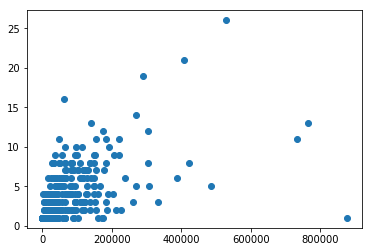

In [17]:
plt.scatter(build_data.square_feet, build_data.floor_count)

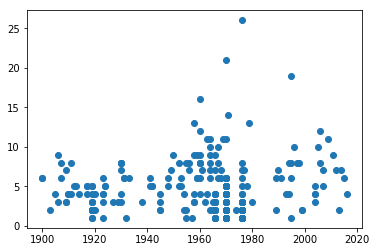

In [18]:
plt.scatter(build_data.year_built, build_data.floor_count)

In [19]:
floor_imputer = LinearRegression()

In [20]:
build_data_no_nan = build_data[~build_data.floor_count.isna()]

In [21]:
build_data_nans = build_data[build_data.floor_count.isna()]

In [22]:
floor_imputer.fit(build_data_no_nan[['square_feet', 'year_built']], np.log1p(build_data_no_nan.floor_count.values.reshape(-1, 1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
imputed_floors = np.exp(floor_imputer.predict(build_data_nans[['square_feet', 'year_built']]) - 1).astype(int)

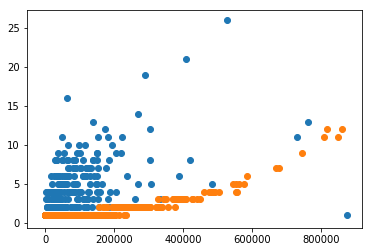

In [24]:
plt.scatter(build_data_no_nan.square_feet, build_data_no_nan.floor_count)
plt.scatter(build_data_nans.square_feet, imputed_floors)

In [25]:
build_data_nans.floor_count = imputed_floors

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
build_data_no_nas = pd.concat([build_data_nans, build_data_no_nan])

## Normalization

`square_feet` has no missing values so we can start by normalising it

In [27]:
from sklearn.preprocessing import MinMaxScaler

### Square Feet

In [28]:
square_feet_scaler = MinMaxScaler()

In [29]:
square_feet_scaler.fit(build_data.square_feet.values.reshape(-1, 1))

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [30]:
square_feet_scaler.transform(np.array(10012).reshape(-1, 1))

array([[0.01112245]])

In [31]:
build_data['square_feet'] = square_feet_scaler.transform(build_data.square_feet.values.reshape(-1, 1))

In [32]:
with open('data/objects/building_metadata_square_feet_normalizer.pkl', 'wb') as f_out:
    pickle.dump(square_feet_scaler, f_out)

### Year Built

In [33]:
year_built_scaler = MinMaxScaler()

In [34]:
year_built_scaler.fit(build_data.year_built.values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [35]:
year_built_scaler.transform(np.array(2010).reshape(-1, 1))

array([[0.94017094]])

In [36]:
build_data['year_built'] = year_built_scaler.transform(build_data.year_built.values.reshape(-1, 1))

In [37]:
with open('data/objects/building_metadata_year_built_normalizer.pkl', 'wb') as f_out:
    pickle.dump(year_built_scaler, f_out)

### Floor Count

In [38]:
floor_count_scaler = MinMaxScaler()

In [39]:
floor_count_scaler.fit(build_data_no_nas.floor_count.values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [40]:
floor_count_scaler.transform(np.array(10).reshape(-1, 1))

array([[0.36]])

In [41]:
build_data_no_nas['floor_count'] = floor_count_scaler.transform(build_data_no_nas.floor_count.values.reshape(-1, 1))

In [42]:
with open('data/objects/building_metadata_floor_count_normalizer.pkl', 'wb') as f_out:
    pickle.dump(floor_count_scaler, f_out)

In [43]:
build_data_no_nas

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,0.00
1,0,1,0,2720,2004.0,0.00
2,0,2,0,5376,1991.0,0.00
3,0,3,0,23685,2002.0,0.00
4,0,4,0,116607,1975.0,0.00
...,...,...,...,...,...,...
1051,12,1051,0,28406,1970.0,0.00
1052,12,1052,11,45305,1970.0,0.04
1054,12,1054,0,204998,1970.0,0.12
1055,12,1055,0,86714,1970.0,0.12


## Finishing

In [44]:
build_data, nas = compress_memory_usage(build_data_no_nas)


Memory usage pre-compression was 0.044219970703125
Memory usage after-compression was 0.030401229858398438
This is  68.75% of the initial size


In [45]:
nas

[]

In [46]:
build_data.to_pickle("data/prep/building_metadata.pkl")

### fin